#### 00_demo.ipynb

- Start here to check what you can do with this small experimental package

In [2]:
using Pkg
Pkg.activate(".")
using MiniOps
using Random, LinearAlgebra
using Plots


  Activating project at `~/MiniOps`
[ Info: Precompiling MiniOps [af2dcb7c-2195-40b8-81d3-f942299158c3] (cache misses: include_dependency fsize change (2), mismatched flags (2))
ERROR: LoadError: UndefVarError: `Op` not defined in `MiniOps`
Stacktrace:
 [1] top-level scope
   @ ~/MiniOps/src/algebra.jl:3
 [2] include(mod::Module, _path::String)
   @ Base ./Base.jl:557
 [3] include(x::String)
   @ MiniOps ~/MiniOps/src/MiniOps.jl:1
 [4] top-level scope
   @ ~/MiniOps/src/MiniOps.jl:31
 [5] include
   @ ./Base.jl:557 [inlined]
 [6] include_package_for_output(pkg::Base.PkgId, input::String, depot_path::Vector{String}, dl_load_path::Vector{String}, load_path::Vector{String}, concrete_deps::Vector{Pair{Base.PkgId, UInt128}}, source::Nothing)
   @ Base ./loading.jl:2881
 [7] top-level scope
   @ stdin:6
in expression starting at /Users/mauriciosacchi/MiniOps/src/algebra.jl:3
in expression starting at /Users/mauriciosacchi/MiniOps/src/MiniOps.jl:1
in expression starting at stdin:6


LoadError: Failed to precompile MiniOps [af2dcb7c-2195-40b8-81d3-f942299158c3] to "/Users/mauriciosacchi/.julia/compiled/v1.11/MiniOps/jl_SV42Id".

In [26]:
# Pad operator (use for FFT-based interp)

n1, n2 = 3,3
p1, p2 = 2, 2
P = pad_op((n1,n2),(p1,p2), (p1,p2))
A = randn(n1,n2)
P*A

7×7 Matrix{Float64}:
 0.0  0.0   0.0         0.0        0.0        0.0  0.0
 0.0  0.0   0.0         0.0        0.0        0.0  0.0
 0.0  0.0   0.0197302  -0.341523   0.063807   0.0  0.0
 0.0  0.0   1.24373     0.219634  -0.671096   0.0  0.0
 0.0  0.0  -0.960453   -0.772603   0.0520631  0.0  0.0
 0.0  0.0   0.0         0.0        0.0        0.0  0.0
 0.0  0.0   0.0         0.0        0.0        0.0  0.0

In [27]:
# Multichannel Convolution

Random.seed!(0)

# Y = A * X Multichannel convolution
# X'= A'* Y Multichannel one-side croscorrlation

h  = [1.0, 2.0, -1.0] # Wavelet 

A  = conv1d_cols_op(h)

nt, ntr = 50, 100
X  = randn(nt, ntr)                     # test input

Y  = A * X

Z  = randn(size(Y))                     # test output

ok, err = adjoint_test(A, X, Z)         # <AX,Z> = <A'Z,X>
@show ok err;


ok = true
err = 1.8364041408825356e-16


In [28]:
# Composition of operators

h = randn(14)
B = conv1d_op(h)       # B*x is 1D convolution of x with h

result = linearity_test(B, randn(10), randn(10); ntests=3, tol=1e-10)
println(B.name, " Linearity test : " , result)

result = adjoint_test(B, randn(10), randn(10+14-1); tol=1e-10)
println(B.name, " Adjoint test   : ", result)

e = opnorm_power(B, randn(10); niter=20)
println(B.name, " Maximum Eig    : ", e)

Sc = scaling_op(3.0)
result = is_selfadjoint(Sc, randn(20); tol=1e-10)
println(Sc.name, " Self adjoint ? ", result)

Sc = scaling_op(0.3)
T=Sc*Sc
T.name


conv1d Linearity test : (true, 2.2163993864992035e-16)
conv1d Adjoint test   : (true, 1.1123978329605024e-16)
conv1d Maximum Eig    : 4.340588258917098
scaling Self adjoint ? (true, 0.0)


Symbol("scaling*scaling")

In [29]:
# 1D FFT Operator 

B = fft_op() # Size agnostic (fft_unplanned)

result = linearity_test(B, randn(128), randn(128); ntests=3, tol=1e-10)
println(B.name, " Linearity test : " , result)

result = adjoint_test(B, randn(128), randn(128); tol=1e-10)
println(B.name, " Adjoint test   : ", result)

e = opnorm_power(B, randn(ComplexF64,128); niter=10)
println(B.name, " Maximum Eig    : ", e)
println(" Size n of B: ", B.n)
println(" Size m of B: ", B.m)

fft_op Linearity test : (true, 2.5213724490766595e-16)
fft_op Adjoint test   : (true, 1.1680973233825286e-15)
fft_op Maximum Eig    : 1.0
 Size n of B: -1
 Size m of B: -1


In [30]:
# 1D FFT Operator (Repeat with operator that knows size (fft_planned))

B = fft_op(randn(128)) 

result = linearity_test(B, randn(128), randn(128); ntests=3, tol=1e-10)
println(B.name, " Linearity test : " , result)

result = adjoint_test(B, randn(128), randn(128); tol=1e-10)
println(B.name, " Adjoint test   : ", result)

e = opnorm_power(B, randn(ComplexF64,128); niter=10)
println(B.name, " Maximum Eig    : ", e)
println(" Size n of B: ", B.n)
println(" Size m of B: ", B.m)

fft_planned Linearity test : (true, 2.542925830474676e-16)
fft_planned Adjoint test   : (true, 6.260319063861603e-16)
fft_planned Maximum Eig    : 1.0
 Size n of B: 128
 Size m of B: 128


In [31]:
# 4D FFT Operator (Repeat with operator that knows size (fft_planned))

B = fft_op(randn(64,64,64,64)) 

result = linearity_test(B, randn(64,64,64,64), randn(64,64,64,64); ntests=3, tol=1e-10)
println(B.name, " Linearity test : " , result)

result = adjoint_test(B, randn(64,64,64,64), randn(64,64,64,64); tol=1e-10)
println(B.name, " Adjoint test   : ", result)

e = opnorm_power(B, randn(ComplexF64,64,64,64,64); niter=10)
println(B.name, " Maximum Eig    : ", e)
println(" Size n of B: ", B.n)
println(" Size m of B: ", B.m)

fft_planned Linearity test : (true, 4.059084294202525e-16)
fft_planned Adjoint test   : (true, 4.244585662462623e-13)
fft_planned Maximum Eig    : 1.0
 Size n of B: 16777216
 Size m of B: 16777216


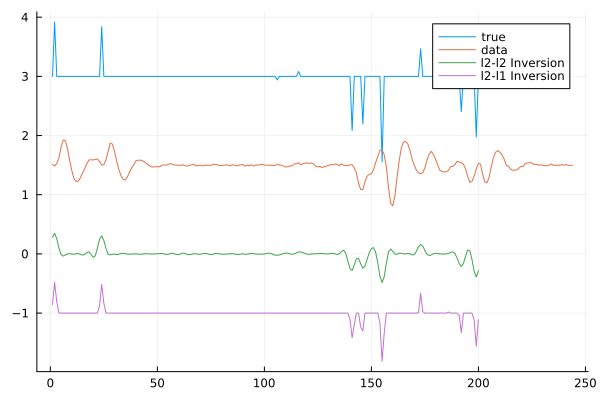

In [32]:
# Seismic Deconvolution Example

# seismicwavelet
  w = seismic_wavelet(f0=34.0,dt=0.002)

# Reflectivity
  M = 200; N = 10; x = zeros(M); x[randperm(M)[1:N]] = randn(N) 

# The wavelet convolution operator 
  C = conv1d_op(w) 

# Make data and add noise 
  y = C*x; y = y + 0.01*randn(size(y))

# Inversion with Damped Least-squares 
  μ = 0.1
  x1  = cgls(C, y, μ, zeros(200); tol=1e-9, max_iter=140)

# Inversion via ISTA (L2-L1) 
  e = opnorm_power(C,randn(200)) # Max eigen of C'C 
  ν = 0.98/e^2.  # Step size 
  x2 = ista(C, y, zeros(200), μ, ν; niter=200, verbose=false);

# Plots
  plot(x.+3,label="true")
  plot!(y.+1.5,label="data")
  plot!(x1, label="l2-l2 Inversion")
  plot!(x2.-1, label="l2-l1 Inversion")



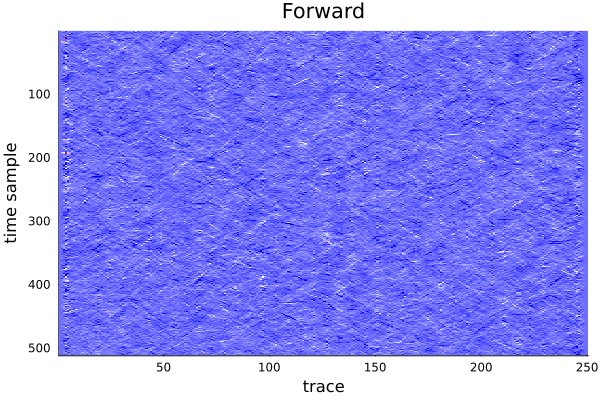

In [101]:
dt = 0.002
nt = 512
t  = collect(0:dt:(nt-1)*dt)

nx = 250
x  = collect(range(-800.0, 800.0; length=nx))

np = 181
p  = collect(range(-0.001, 0.001; length=np))

# windows implied by nx, choose win_size, overlap
win_traces, taper, xref_idx = build_offset_windows(nx; win_size=12, overlap=0.5)
nwin = length(win_traces)

# 3D local model m(τ,p,ℓ)
w = seismic_wavelet(f0 = 20.0, dt = dt)
nw = length(w)
m3 = zeros(Float64, nt, np, nwin)
m3[55:55+nw-1,21,2].=w
m3[250:250+nw-1,23,4].=-w
m3[110:110+nw-1,21,5].=-w
m3[310:310+nw-1,9,8].=w/2
m3[410:410+nw-1,5,9].=w
m3[210:210+nw-1,53,13].=w
m3[410:410+nw-1,25,19].=w
m3 = m3 + randn(size(m3)).^5
# e.g., put same event in each ℓ with varying amplitude, or different p per ℓ, etc.

d = local_lin_rt3d_fwd(m3, t, x, p; win_size=12, overlap=0.5)

m3_adj = local_lin_rt3d_adj(d, t, x, p; win_size=12, overlap=0.5)
heatmap(d,yflip=true,title="Forward",cmap=:seismic,cbar=false,ylabel="time sample",xlabel="trace")

#savefig("lr2.pdf")

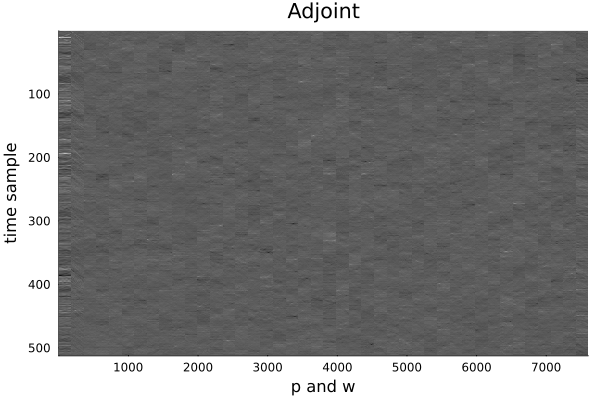

In [102]:
n1,n2,n3=size(m3_adj)
heatmap(reshape(m3_adj,512,n2*n3),title="Adjoint",yflip=true,cmap=:grays,cbar=false,ylabel="time sample", xlabel="p and w")
#println(size(m3))
#savefig("lr3.pdf")

In [97]:
nt,np,nwin=size(m3_adj)
heatmap(reshape(m3,nt,np*nwin),title="Local RT Coefs.",yflip=true,cmap=:grays,cbar=false,ylabel="time sample", xlabel="p and w")
println(size(m3))
#savefig("lr1.pdf")

(512, 181, 34)


In [103]:
m1 = randn(nt,np,nwin)
d1 = local_lin_rt3d_fwd(m1, t, x, p; win_size=12, overlap=0.5)
d2 = randn(size(d1))
m2 = local_lin_rt3d_adj(d2, t, x, p; win_size=12, overlap=0.5)

println("Dot prod test:", sum(m1.*m2)-sum(d1.*d2))

Dot prod test:1.1368683772161603e-13
